In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import monpa
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

monpa.use_gpu(True)   # 記得去執行階段的地方啟用GPU

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.
GPU unavailable.


In [2]:
from sklearn import svm
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
transaction_df = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/mid term database/bda2024_微股力_個股交易數據-2年.csv")
transaction_df['stock_symbol'] = transaction_df['stock_symbol'].astype(str)
transaction_df['date'] = pd.to_datetime(transaction_df['date']).dt.date
transaction_df

C:\Users\Bryce Chiu\AppData\Local\Temp\ipykernel_15176\3957644596.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction_df = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/mid term database/bda2024_微股力_個股交易數據-2年.csv")


,stock_name,stock_symbol,open,high,low,close,volume,date
0,日馳,1526,47.55,48.45,47.55,48.30,138,2022-03-01
1,日馳,1526,48.30,48.30,47.40,47.95,153,2022-03-02
2,日馳,1526,48.45,48.70,47.80,48.10,120,2022-03-03
3,日馳,1526,47.95,47.95,47.55,47.60,165,2022-03-04
4,日馳,1526,47.65,47.65,45.30,45.65,514,2022-03-07
...,...,...,...,...,...,...,...,...
1154220,統一,1216,76.20,78.60,76.00,77.20,20607,2023-06-16
1154221,統一,1216,76.80,78.80,76.40,78.80,16466,2023-06-19
1154222,統一,1216,78.00,78.70,77.10,78.20,16015,2023-06-20
1154223,統一,1216,78.00,78.00,76.30,77.40,8524,2023-06-21


In [4]:
target_stock_name_1 = ['廣達', '緯創', '台積電', '創意', '世芯-KY', '智原', '智邦', '信驊', '譜瑞-KY', '日月光投控', '台達電', '光寶科', '群光', '奇鋐', '金像電', '台燿', '嘉澤', '技嘉', '緯穎', '英業達', '鴻海', '聯發科', '聯茂', 'M31']
target_stock_name_2 = ['AMAX-KY','緯創','凌群','創意','東元','英業達','原相','長佳智能','精誠','鴻海','華碩','微星','金寶','聯發科','世芯-KY','京元電子','美律','亞信','研華','台積電','宏碁','走著瞧-創','鈺創','廣達','凌華','零壹','台達電','樺漢','群電']

#get rid of the duplicate stock names
target_stock_name = target_stock_name_1 + target_stock_name_2
target_stock_name = list(set(target_stock_name))

In [5]:
dates_list = sorted(list(set(transaction_df["date"])))
dates_list

[datetime.date(2022, 3, 1),
 datetime.date(2022, 3, 2),
 datetime.date(2022, 3, 3),
 datetime.date(2022, 3, 4),
 datetime.date(2022, 3, 7),
 datetime.date(2022, 3, 8),
 datetime.date(2022, 3, 9),
 datetime.date(2022, 3, 10),
 datetime.date(2022, 3, 11),
 datetime.date(2022, 3, 14),
 datetime.date(2022, 3, 15),
 datetime.date(2022, 3, 16),
 datetime.date(2022, 3, 17),
 datetime.date(2022, 3, 18),
 datetime.date(2022, 3, 21),
 datetime.date(2022, 3, 22),
 datetime.date(2022, 3, 23),
 datetime.date(2022, 3, 24),
 datetime.date(2022, 3, 25),
 datetime.date(2022, 3, 28),
 datetime.date(2022, 3, 29),
 datetime.date(2022, 3, 30),
 datetime.date(2022, 3, 31),
 datetime.date(2022, 4, 1),
 datetime.date(2022, 4, 6),
 datetime.date(2022, 4, 7),
 datetime.date(2022, 4, 8),
 datetime.date(2022, 4, 11),
 datetime.date(2022, 4, 12),
 datetime.date(2022, 4, 13),
 datetime.date(2022, 4, 14),
 datetime.date(2022, 4, 15),
 datetime.date(2022, 4, 18),
 datetime.date(2022, 4, 19),
 datetime.date(2022, 4, 2

In [7]:
# if the sum of the stock price in stock_name n days later is higher than the sum of stock price today by more than 5%, then label today's disc_df["rise"] as 1
# if the sum of the stock price in stock_name n days later is lower than the sum of stock price today by more than 5%, then label today's disc_df["rise"] as -1
# if the sum of the stock price in stock_name n days later is within 5% of the sum of stock price today, then label today's disc_df["rise"] as 0

n = 7
m = 0.05
return_array = np.zeros(len(dates_list[:-7]))
for i in range(0,len(dates_list[:-7])):
    #check the availability of stock price data of stock_name today
    stock_data_today = transaction_df[transaction_df["date"] == dates_list[i]]
    stock_data_today_name = stock_data_today["stock_name"].values

    #check the availability of stock price data of stock_name n days later
    stock_data_later = transaction_df[transaction_df["date"] == dates_list[i + n]]
    stock_data_later_name = stock_data_later["stock_name"].values

    #get the available stocks on both today and later
    stock_name = [stock for stock in stock_data_today_name if stock in stock_data_later_name]

    stock_name = [stock for stock in stock_name if stock in target_stock_name]
    
    if len(stock_name) == 0:
        continue
    
    percentage_change_sum = 0
    
    for stock in stock_name:
        if stock in stock_data_today_name and stock in stock_data_later_name:
            tmp = stock_data_later[stock_data_later["stock_name"] == stock]["close"].values[0] - stock_data_today[stock_data_today["stock_name"] == stock]["open"].values[0]
            tmp = tmp/stock_data_today[stock_data_today["stock_name"] == stock]["open"].values[0]
            percentage_change_sum += tmp

#     #calculate the percentage change of stock price, and label the data in disc_df["rise"]
#     percentage_change = (stock_price_later - stock_price_today) / stock_price_today
    
    percentage_change = percentage_change_sum/len(stock_name)
    return_array[i] = percentage_change

In [99]:
trade_array = return_array
trade_array[trade_array >= 0.05] = 1
trade_array[trade_array <= -0.05] = -1
trade_array[(trade_array < 0.05 ) & (trade_array > -0.05)] = 0

In [100]:
trade_data = pd.DataFrame({
    'Date': dates_list[:-7],
    'trade_signal': trade_array
})
trade_data

,Date,trade_signal
0,2022-03-01,0.0
1,2022-03-02,0.0
2,2022-03-03,0.0
3,2022-03-04,1.0
4,2022-03-07,0.0
...,...,...
473,2024-01-31,0.0
474,2024-02-01,0.0
475,2024-02-02,0.0
476,2024-02-05,0.0


In [101]:
trade_data.to_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/prediction/trade_list.csv")

In [10]:
feature_dim = 384

In [230]:
train_data = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/Folder16/train_data202306.csv")  #這裡要改成你的硬碟的相對位置
test_data = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/Folder16/test_data202310.csv")   #這裡也是
if "segmented_content" in train_data:
    train_data = train_data.drop(columns=["segmented_content"])
if "segmented_content" in test_data:
    test_data = test_data.drop(columns=["segmented_content"])
train_data['post_time'] = pd.to_datetime(train_data['post_time'])
test_data['post_time'] = pd.to_datetime(test_data['post_time'])
train_data

,id,post_time,content,rise,post_id
0,1692059875067_F0DCU,2023-08-15,0050玩的是月~年 \n人家玩的是當日 就是一個心跳\n我看過是晚幾秒賣出跌20,1.0,57135
1,1690162016112_mobileM,2023-07-24,7-24 作戰區------住VIP套房等崩盤,-1.0,119611
2,1695846554661_F0DCU,2023-09-28,已經刪除的內容就像 Dcard 一樣，錯過是無法再相見的！,1.0,61849
3,1690934097903_F0DCU,2023-08-01,趕緊賣 會跌一陣子,-1.0,53781
4,1690225841230_F0DCU,2023-07-24,恭喜獲利入袋,-1.0,48158
...,...,...,...,...,...
4995,1686383819425_F0DCU,2023-06-09,https://megapx-assets.dcard.tw/images/251ace3a...,1.0,45262
4996,1690398246274_F0DCU,2023-07-26,百年難得一見的武林奇才,-1.0,49978
4997,1690936895877_F0DCU,2023-08-01,有個理論\n\n不是妳該賺到的錢怎麼樣都賺不到,-1.0,53625
4998,1692245931747_mobileM,2023-08-17,以下胡亂猜測請勿相信 截至目前為止 1. 估計到收盤為止 成交量也不可能超過上週平均成交量...,1.0,123757


In [14]:
start_time = time.time()
monpa.use_gpu(True)
stopwords = [line.rstrip()
             for line in open("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/stopwords.txt", encoding='utf8')]
filtered_train_data = train_data.fillna('')
filtered_train_data['content'].str.strip()
filtered_test_data = test_data.fillna('')
filtered_test_data['content'].str.strip()
vectorizer = TfidfVectorizer(
    use_idf=True, stop_words=stopwords, tokenizer=monpa.cut, max_features=feature_dim)
X = vectorizer.fit_transform(
    pd.concat([filtered_train_data["content"], filtered_test_data["content"]]))

print(time.time() - start_time)

GPU unavailable.


C:\Users\Bryce Chiu\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['[', ']', 'a', '一點', '下', '下去', '不可', '不斷', '主義', '之間', '二話', '些', '亦', '亮話', '人意', '今', '令', '以來', '以外', '以後', '位', '何樂', '使', '例外', '保留', '倒', '假', '偶', '充', '兒', '全', '兩', '具體', '再', '凡', '分批', '刻', '刻間', '前', '加', '勿', '卻', '口兒', '古', '只', '叮', '呆呆', '呼', '唷', '問', '啪', '喔', '噠', '嚴', '外', '夠', '大張', '大面兒', '天', '天窗', '好', '少', '巧', '差', '已', '年', '年覆', '度', '式', '彈指', '得及', '忽', '恰', '情', '慢', '慣', '成', '或少', '手段', '打開', '抗拒', '抵', '挨', '挨家', '挨戶', '挨門', '接連', '換句', '擇', '敞開', '新', '旗鼓', '日', '日覆', '早', '時', '晚', '暗地', '會兒', '末', '樂乎', '樣', '樣子', '權', '次', '止', '正', '歸根', '每刻', '每時', '毫', '決', '況', '消', '為止', '烏', '無', '無到', '無阻', '熱', '爾', '特', '獨厚', '由此', '番', '皆', '益善', '盡力', '盡心', '目前', '相反', '相對', '真', '瞧', '知', '短', '社會', '種', '窮年', '竭力', '策略', '簡而言', '簡言', '累月', '結底', '綜'

210.28253269195557


In [74]:
document_vector = pd.DataFrame(
    X.toarray(), columns=vectorizer.get_feature_names_out())
label = pd.concat(
    [filtered_train_data["rise"], filtered_test_data["rise"]], ignore_index=True).astype(int)
post_id = pd.concat(
    [filtered_train_data["post_id"], filtered_test_data["post_id"]], ignore_index=True)
document_type = pd.concat(
    [pd.Series(["train"]*5000),  pd.Series(["test"]*1000)], ignore_index=True)
document_vector["label"] = label
document_vector["post_id"] = post_id
document_vector["type"] = document_type
document_vector

,,,,,,,,,dcard,https,...,高,高點,鴻海,點,．,／,😂,label,post_id,type
5900,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,67402,test
5901,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,132335,test
5902,0.218556,0.611535,0.155374,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,148329,test
5903,0.176823,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,68593,test
5904,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.765142,0.0,0.0,0.0,0.0,1,131940,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.864924,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,67206,test
5996,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,67273,test
5997,0.871874,0.000000,0.000000,0.0,0.1052,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,148339,test
5998,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1,68189,test


In [15]:
document_vector.to_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/document_vector/document_vector19.csv")

NameError: name 'document_vector' is not defined

In [231]:
data = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/document_vector/document_vector16.csv", index_col=0) #讀你上面那個向量的.csv檔
data

,,,,,,,,dcard,https,0050,...,鴻海,點,️,／,😂,🤣,🥲,label,post_id,type
0,0.384104,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.335169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,57135,train
1,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,119611,train
2,0.122140,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.385997,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,61849,train
3,0.257697,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,53781,train
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,48158,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,63618,test
5996,0.676667,0.334141,0.0,0.0,0.164941,0.167578,0.177309,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,147708,test
5997,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,128098,test
5998,0.205663,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,126748,test


In [232]:
features = data.iloc[:, :-3].to_numpy()
labels = data.iloc[:, -3].to_numpy()
X_train = features[:5000]
y_train = labels[:5000]
X_test = features[5000:]
y_test = labels[5000:]

In [233]:
start_time = time.time()

svm_model = SVC(kernel='rbf', C=1, gamma='scale')

# Perform grid search to find the best parameters to avoid overfitting
param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(svm_model, param_grid, cv=5)

grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print(f"Best parameters:\n{grid_search.best_params_}")

best_model = grid_search.best_estimator_

# Evaluate the model on the train set
y_pred1 = best_model.predict(X_train)
print('\nTraining Accuracy:\n', classification_report(y_train, y_pred1, zero_division = 0))

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print('\nTesting Accuracy:\n', classification_report(y_test, y_pred, zero_division = 0))
print(time.time() - start_time)

Best parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Training Accuracy:
               precision    recall  f1-score   support

          -1       0.69      0.10      0.18      1834
           1       0.65      0.97      0.78      3166

    accuracy                           0.65      5000
   macro avg       0.67      0.54      0.48      5000
weighted avg       0.67      0.65      0.56      5000


Testing Accuracy:
               precision    recall  f1-score   support

          -1       0.41      0.03      0.06       403
           1       0.60      0.97      0.74       597

    accuracy                           0.59      1000
   macro avg       0.51      0.50      0.40      1000
weighted avg       0.52      0.59      0.46      1000

209.09719014167786


In [234]:
test_set = test_data
test_set['prediction'] = y_pred
test_set.to_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/prediction/result16.csv")

In [235]:
test_set = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/prediction/result16.csv")
result = test_set[['post_time', 'prediction']]
result = result.rename(columns = {'post_time': 'Date'})
result['Date'] = pd.to_datetime(result['Date'])
result = result.groupby('Date')['prediction'].value_counts().unstack(fill_value=0)
#result['proportion'] = +result[1]/result.sum(axis = 1)
result['proportion'] = (result[-1]*(-1)+result[1])/result.sum(axis = 1)
print(result)
conditions = [
    result['proportion'] < -0.3,  # 條件1
    result['proportion'] > 0.3,   # 條件2
    (result['proportion'] >= -0.3) & (result['proportion'] <= 0.3)  # 條件3
]
choices = [-1, 1, 0]
result['trade'] = np.select(conditions, choices)
result['trade']

prediction  -1    1  proportion
Date                           
2023-10-12   3  147    0.960000
2023-10-13   6  116    0.901639
2023-10-17   3  128    0.954198
2023-10-26   6  132    0.913043
2023-10-27   6  153    0.924528
2023-10-30   3  134    0.956204
2023-10-31   2  161    0.975460


Date
2023-10-12    1
2023-10-13    1
2023-10-17    1
2023-10-26    1
2023-10-27    1
2023-10-30    1
2023-10-31    1
Name: trade, dtype: int32

In [239]:
trade_data = pd.merge(trade_data, result['trade'], on='Date', how='left')
trade_data['trade_predict'] = trade_data['trade_predict'].fillna(trade_data['trade'])
trade_data.drop('trade', axis=1, inplace=True)
trade_data

,Date,trade_signal,trade_predict
300,2023-05-24,-1.0,1.0
301,2023-05-25,-1.0,NaN
302,2023-05-26,0.0,NaN
303,2023-05-29,0.0,NaN
304,2023-05-30,0.0,1.0
...,...,...,...
473,2024-01-31,0.0,NaN
474,2024-02-01,0.0,NaN
475,2024-02-02,0.0,NaN
476,2024-02-05,0.0,NaN


In [3]:
trade_data = pd.read_csv("C:/Users/Bryce Chiu/Desktop/大數據與商業分析/mid project/0TFolder/prediction/trade_list.csv", index_col = 0)
trade_data['Date'] = pd.to_datetime(trade_data['Date'])
trade_data['trade_predict'] = np.nan

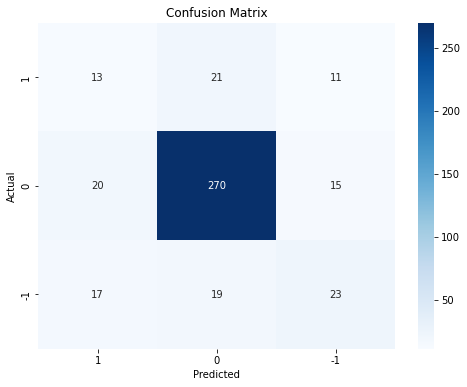

In [255]:
cm = confusion_matrix(tmp['trade_signal'], tmp['trade_predict'], labels=[1, 0, -1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[1, 0, -1], yticklabels=[1, 0, -1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [257]:
accuracy = accuracy_score(tmp['trade_signal'], tmp['trade_predict'])
f1 = f1_score(tmp['trade_signal'], tmp['trade_predict'], average='weighted')
precision = precision_score(tmp['trade_signal'], tmp['trade_predict'], average='weighted')
recall = recall_score(tmp['trade_signal'], tmp['trade_predict'], average='weighted')
trade_count = tmp['trade_signal'].value_counts()
trade_probability = (len(tmp)-trade_count[0])/len(tmp)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"出手率："{trade_probability})

(0.7481662591687042, 0.7463332448706463)

In [ ]:
print(y_train)
print(f"1:{len(y_train[y_train==1])}")
print(f"-1:{len(y_train[y_train==-1])}")

In [ ]:
print(y_pred1)
print(f"1:{len(y_pred1[y_pred1==1])}")
print(f"-1:{len(y_pred1[y_pred1==-1])}")

In [ ]:
print(y_test)
print(f"1:{len(y_test[y_test==1])}")
print(f"-1:{len(y_test[y_test==-1])}")

In [132]:
print(y_pred)
print(f"1:{len(y_pred[y_pred==1])}")
print(f"-1:{len(y_pred[y_pred==-1])}")

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1